In [28]:
test_semantic_model_url = '/tmp/llm/semantic_model.txt' 
questions_url           = '/tmp/llm/questions.json'
SF                      = 0.1
max_attempts            = 1
TIMEOUT_SECONDS         = 180  
output_dir              = "/tmp/llm"
model0                  = "o3-mini"
model1                  = "qwen3-30b-a3b-2507"
model2                  = "gpt-oss-20b"

# Setup

In [29]:
import requests
import json
import duckdb
import pathlib
import time
import re
from   openai import AzureOpenAI, OpenAIError
import datetime
import os
import threading
import pandas as pd


In [30]:
if SF <1 :
 schema = f"DS{str(SF).replace('.', '_')}"
else :
 schema = f'DS{SF:02d}'
os.makedirs(output_dir, exist_ok=True)
db_path = output_dir +"/"+ schema +".duckdb"
if not pathlib.Path(db_path).exists():
    con = duckdb.connect(db_path)
    con.sql("SET memory_limit = '14GB' ")
    con.sql(f"CALL dsdgen(sf={SF})")
    con.close()
con = duckdb.connect()
con.sql(f""" attach '{db_path}' as ds(read_only) ; use ds """)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [31]:
def get_ai_response(user_message, LLM, provider, api_key=None, azure_endpoint=None, azure_api_version=None):
    system_prompt = ""
    try:
        github_response = requests.get(test_semantic_model_url)
        github_response.raise_for_status()
        system_prompt = github_response.text.strip()
    except requests.RequestException as e:
        try:
            with open(test_semantic_model_url, 'r', encoding='utf-8') as f:
                system_prompt = f.read().strip()
        except Exception as e2:
            print(f"Error loading system prompt from local path: {e2}")
            return f"Error fetching system prompt: {e2}"

    generated_text = None
    data = None

    if provider == "ollama":
        url = 'http://127.0.0.1:1234/v1/chat/completions'
        headers = {'Content-Type': 'application/json'}
        payload = {
            'model': LLM,
            'messages': [
                {'role': 'system', 'content': system_prompt},
                {'role': 'user', 'content': user_message}
            ],
            'stream': False
        }
        try:
            response = requests.post(url, headers=headers, json=payload)
            response.raise_for_status()
            data = response.json()
            generated_text = data.get('choices', [{}])[0].get('message', {}).get('content', '')
            if generated_text:
                generated_text = generated_text.replace("<think>", "").replace("</think>", "")
        except requests.RequestException as e:
            return f"Error with LM Studio API request: {e}"
        except (KeyError, IndexError, AttributeError) as e:
            return f"Unexpected response format from LM Studio: {e}\nFull response data: {data}"

    elif provider == "azure_foundry":
        if not azure_endpoint or not azure_api_version or not api_key:
            return "Azure provider requires 'azure_endpoint', 'azure_api_version', and 'api_key' parameters."

        try:
            client = AzureOpenAI(
                api_version=azure_api_version,
                azure_endpoint=azure_endpoint,
                api_key=api_key,
            )

            response = client.chat.completions.create(
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_message}
                ],
                model=LLM,
            )

            generated_text = response.choices[0].message.content

        except Exception as e:
            return f"An error occurred with Azure OpenAI: {e}"



    else:
        return f"Unsupported provider for this test setup: {provider}. Supported providers are 'ollama' (LM Studio), 'azure_foundry', and 'gemini'."

    if not isinstance(generated_text, str):
         print(f"Generated text is not a string (type: {type(generated_text)}). Cannot clean.")
         if generated_text is None:
              return "Could not retrieve generated text from provider response."
         else:
              return f"Received unexpected output type from {provider}: {type(generated_text)}. Value: {generated_text}"

    # Enhanced text cleaning to extract SQL
    cleaned_text = generated_text
    
    # Simple approach: extract content after final channel message
    # Look for the pattern: <|channel|>final<|message|> and take everything after it
    final_message_match = re.search(r'<\|channel\|>final<\|message\|>(.*?)(?:<\|end\|>|$)', cleaned_text, re.DOTALL)
    if final_message_match:
        cleaned_text = final_message_match.group(1).strip()
    else:
        # Fallback: look for any final message pattern
        message_matches = re.findall(r'<\|message\|>(.*?)(?:<\|end\|>|$)', cleaned_text, re.DOTALL)
        if message_matches:
            cleaned_text = message_matches[-1].strip()  # Take the last message
        else:
            # Remove all chat template tokens if no specific pattern found
            cleaned_text = re.sub(r'<\|[^|]*\|>', '', cleaned_text).strip()
    
    # Remove any remaining template tokens
    cleaned_text = re.sub(r'<\|[^|]*\|>', '', cleaned_text).strip()
    
    # Remove thinking tags if present
    cleaned_text = re.sub(r'<think>.*?</think>', '', cleaned_text, flags=re.DOTALL | re.IGNORECASE).strip()
    
    # Clean up code blocks if present
    sql_in_blocks = re.findall(r'```(?:sql|duckdb)?\s*([\s\S]*?)\s*```', cleaned_text, flags=re.IGNORECASE)
    if sql_in_blocks:
        cleaned_text = sql_in_blocks[-1].strip()
    
    # Final cleanup
    cleaned_text = cleaned_text.replace("```sql", "").replace("```duckdb", "").replace("```", "").strip()
    
    # Simple extraction: return everything after the first '--' comment
    # This handles LM Studio's new format that puts SQL after explanatory text and comments
    double_dash_pos = cleaned_text.find('--')
    if double_dash_pos != -1:
        # Find the end of the comment line (newline after --)
        comment_end = cleaned_text.find('\n', double_dash_pos)
        if comment_end != -1:
            # Return everything after the comment line
            sql_after_comment = cleaned_text[comment_end + 1:].strip()
            if sql_after_comment:
                return sql_after_comment
    
    return cleaned_text

In [32]:
def execute_sql_with_retry(query, test_model, provider, api_key, azure_endpoint, azure_api_version):
    attempt = 1
    current_query = query.strip()

    while attempt <= max_attempts:
        con.sql("SET enable_progress_bar_print = false")
        con.sql("SET progress_bar_time = 0")

        result_container = {"result": None, "error": None}

        def query_thread():
            try:
                result_container["result"] = con.execute(current_query).fetchdf()
            except duckdb.InterruptException:
                result_container["error"] = f"Query interrupted after timeout of {TIMEOUT_SECONDS} seconds."
            except Exception as e:
                result_container["error"] = str(e)

        thread = threading.Thread(target=query_thread)
        thread.start()

        start_time = time.time()
        while thread.is_alive():
            elapsed = time.time() - start_time
            if elapsed > TIMEOUT_SECONDS:
                con.interrupt()
                thread.join()
                return f"Query execution timed out after {TIMEOUT_SECONDS} seconds.", attempt, "query runs forever"
            time.sleep(0.1)

        if result_container["error"]:
            error_message = result_container["error"].lower()
            if "syntax" not in error_message and "parser" not in error_message and "binder" not in error_message:
                return f"Non-syntax error: {result_container['error']}", attempt, current_query

            print(current_query)
            print(f"Attempt {attempt}/{max_attempts} failed with syntax error: {result_container['error']}")

            if attempt == max_attempts:
                return f"Max attempts reached. Last error: {result_container['error']}", attempt, current_query

            message = (
                f"The following SQL query has a syntax error: '{current_query}'.\n"
                f"Error message: {result_container['error']}\n"
                f"Please provide the corrected SQL query. Return only the corrected query without explanation."
            )

            corrected_query = get_ai_response(message, test_model, provider, api_key, azure_endpoint, azure_api_version)

            if corrected_query.startswith("Error"):
                return f"Failed to get corrected query : {corrected_query}", attempt, current_query

            current_query = corrected_query.strip()
            attempt += 1
        else:
            return result_container["result"], attempt, current_query

    return "Unexpected error or loop termination", attempt, current_query


In [33]:
def ask_question(questions, test_model,provider,api_key=None, azure_endpoint=None, azure_api_version=None):
    results_data = [] 
    for i, x in enumerate(questions):
        print(f"Question {i+1}: {x}") # Keep or remove print as needed
        start_time = time.time()
        sql_query_or_error = get_ai_response(x, test_model, provider, api_key, azure_endpoint, azure_api_version)
        print(sql_query_or_error) # Keep or remove print as needed
        query_result_data_json = [] # Initialize as an empty list for JSON result
        attempts_count = None
        error_details = None # Initialize error_details
        if sql_query_or_error is None or sql_query_or_error.startswith("Error"):
            # If get_ai_response returned an error or None, store the error string
            error_message = sql_query_or_error if sql_query_or_error is not None else "AI response was None"
            # print(f"Failed to get query from AI: {error_message}") # Keep or remove print
            # print("Execution: SKIPPED (AI error)") # Keep or remove print
            error_details = f"AI Error: {error_message}" # Store error details
            # query_result_data_json remains empty []
            result_row_count = 0 # Result count is 0 on error
        else:
            result_from_execution, attempts_count,query_returned = execute_sql_with_retry(sql_query_or_error, test_model,provider,api_key, azure_endpoint, azure_api_version)

            display(result_from_execution)
            is_successful = isinstance(result_from_execution, pd.DataFrame)

            if is_successful:
                print("Execution: SUCCESS") # Keep or remove print
                query_result_data_json = result_from_execution.to_dict('records')
                error_details = None # No error details on success
                result_row_count = len(result_from_execution) # Calculate row count
            else:
                print("Execution: FAILED") # Keep or remove print
                #query_result_data_json remains empty []
                error_details = f"Execution Error: {result_from_execution}" # Store error details
                result_row_count = 0 # Result count is 0 on failure


        end_time = time.time()
        duration = round(end_time - start_time, 2)
        print(f"\nExecution Time: {duration:.2f} seconds") # Keep or remove print
        print(f" ############################### ") # Keep or remove print
        results_data.append({
            "model" : test_model,
            "SF" : SF,
            "timestamp": timestamp,
            "nbr": i + 1,
            "question": x,
            "duration_s": duration, 
            "sql_query": query_returned, 
            "attempts": attempts_count,
            "result": query_result_data_json, 
            "result_count": result_row_count, 
            "error_details": error_details 
        })
    log_dir = output_dir +"/log"
    os.makedirs(log_dir, exist_ok=True)
    sanitized_model = re.sub(r'[\\/*?:"<>|]', '_', test_model)
    output_filename = f"{timestamp}_{sanitized_model}.json"
    output_path = os.path.join(log_dir, output_filename)
    try:
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(results_data, f, indent=4)
            f.flush()
            os.fsync(f.fileno())
        return f"Successfully processed {len(questions)} questions. Results saved to {output_path}"
    except IOError as e:
        return f"Error saving results to {output_path}: {e}"
    except Exception as e:
        return f"An unexpected error occurred during file saving: {e}"

In [34]:
def display_side_by_side(nbr, model1, model2):
    print(f"question {nbr} : " + duckdb.sql(f" select question from results_filtered where nbr = {nbr}  ").fetchone()[0])
    try:
        sql_query1 = duckdb.sql(f""" select sql_query from results_filtered where nbr = {nbr} and model = '{model1}' """).fetchone()[0]
        sql_query2 = duckdb.sql(f""" select sql_query from results_filtered where nbr = {nbr} and model = '{model2}' """).fetchone()[0]
        df1 = con.sql(sql_query1).df()        
        df2 = con.sql(sql_query2).df() 
        side_by_side = pd.concat([df1, df2], axis=1, keys=[model1, model2])
        display(side_by_side)
        # Print the SQL queries clearly labeled
        print(f"{model1} SQL Query:")
        print("--------------------")
        print(sql_query1)
        print("\n") # Add a newline for separation

        print(f"{model2} SQL Query:")
        print("--------------------")
        print(sql_query2)
        print("\n") # Add a newline for separation
    except Exception as e:
        print(f"Error executing query for nbr {nbr}: {e}")

In [35]:
# get the questions from GitHub, if error try local path
try:
    response = requests.get(questions_url)
    response.raise_for_status()
    questions = json.loads(response.text)
    print("Successfully retrieved questions from GitHub.")
except (requests.exceptions.RequestException, json.JSONDecodeError) as e:
    print(f"Error retrieving from GitHub: Trying local path...")
    try:
        with open(questions_url, 'r', encoding='utf-8') as f:
            questions = json.load(f)
        print("Successfully loaded questions from local path.")
    except Exception as e2:
        print(f"Error loading questions from local path: {e2}")
        questions = []

Error retrieving from GitHub: Trying local path...
Successfully loaded questions from local path.


# Run Tests

In [36]:
%%time
#ask_question(questions,"o3-mini","azure_foundry",os.getenv("o3_mini_key"), os.getenv("llm_endpoint"),"2025-01-01-preview" )

CPU times: total: 0 ns
Wall time: 0 ns


In [37]:
#%%time
#ask_question(questions,model1,"ollama")

In [38]:
#%%time
# Uncomment to run the third model individually
#ask_question(questions,model2,"ollama")

# Model Comparison Results
Compare model1 vs model2 against the source of truth (model0)

In [39]:
# OPTIMIZED COMPARISON LOGIC - Much Faster!
# Pre-calculate sorted hashes to avoid repeated expensive operations
# FOCUS ON VALUES ONLY - IGNORE COLUMN NAMES COMPLETELY

# Load and prepare data with pre-calculated hashes focusing only on values
duckdb.sql(f"""
    CREATE OR REPLACE VIEW results_all AS
    SELECT *,
    cardinality(result[1]) as nbr_columns,
    [result_count , nbr_columns] as result_shape,
    -- Extract only values (ignore column names completely)
    flatten(array_transform(result, x -> json_extract(json(x), '$.*'))) as all_values,
    -- Hash of all values for exact comparison
    hash(flatten(array_transform(result, x -> json_extract(json(x), '$.*')))) as values_hash,
    -- Sorted hash for order-independent comparison (values only)
    hash(array_sort(flatten(array_transform(result, x -> json_extract(json(x), '$.*'))))) as sorted_values_hash
    FROM read_json_auto('{output_dir}/log/*.json') 
    WHERE model in ('{model0}', '{model1}', '{model2}') and SF = '{SF}' 
""")

duckdb.sql(f"""
    CREATE OR REPLACE TEMP TABLE results_filtered_three AS
    SELECT * FROM results_all  
    WHERE timestamp = (SELECT max(timestamp) FROM results_all r2 WHERE r2.model = results_all.model)
""")



# Enhanced comparison focusing exclusively on values with FIXED superset logic
comparison_table = duckdb.sql(f"""
    WITH source_results AS (
        SELECT nbr, 
               all_values as source_values,
               sorted_values_hash as source_sorted_hash,
               result_count as source_rows
        FROM results_filtered_three 
        WHERE model = '{model0}' AND error_details IS NULL
    ),
    model_scores AS (
        SELECT 
            r.model,
            r.nbr,
            r.result_count,
            r.duration_s,
            s.source_rows,
            CASE 
                WHEN r.error_details IS NOT NULL THEN 'error'
                -- Exact values match (same sorted hash) - ORDER AND VALUES IDENTICAL
                WHEN r.sorted_values_hash = s.source_sorted_hash THEN 'exact'
                -- IMPROVED SUPERSET LOGIC: If all source values exist in model result
                -- This handles cases where models return extra columns or calculations
                WHEN array_has_all(r.all_values, s.source_values) THEN 'superset'
                -- SUBSET: If model result is contained in source (shouldn't happen often)
                WHEN array_has_all(s.source_values, r.all_values) THEN 'subset'
                ELSE 'mismatch'
            END as match_type
        FROM results_filtered_three r
        LEFT JOIN source_results s ON r.nbr = s.nbr
        WHERE r.model IN ('{model1}', '{model2}')
    )
    SELECT 
        model,
        SUM(CASE WHEN match_type = 'exact' THEN 1 ELSE 0 END) as exact_matches,
        SUM(CASE WHEN match_type = 'superset' THEN 1 ELSE 0 END) as superset_matches,
        SUM(CASE WHEN match_type = 'subset' THEN 1 ELSE 0 END) as subset_matches,
        SUM(CASE WHEN match_type = 'mismatch' THEN 1 ELSE 0 END) as mismatches,
        SUM(CASE WHEN match_type = 'error' THEN 1 ELSE 0 END) as errors,
        SUM(CASE WHEN match_type IN ('exact', 'superset', 'subset') THEN 1 ELSE 0 END) as total_correct,
        ROUND(SUM(CASE WHEN match_type IN ('exact', 'superset', 'subset') THEN 1 ELSE 0 END) / 20.0 * 100, 1) as accuracy_percent,
        ROUND(SUM(duration_s), 1) as total_duration_seconds,
        ROUND(AVG(duration_s), 2) as avg_duration_per_question
    FROM model_scores
    GROUP BY model
    ORDER BY model
""").df()

print()
display(comparison_table)

,model,exact_matches,superset_matches,subset_matches,mismatches,errors,total_correct,accuracy_percent,total_duration_seconds,avg_duration_per_question
0,gpt-oss-20b,14.0,3.0,0.0,2.0,1.0,17.0,85.0,2071.1,103.55
1,qwen3-30b-a3b-2507,12.0,1.0,2.0,4.0,1.0,15.0,75.0,1651.0,82.55


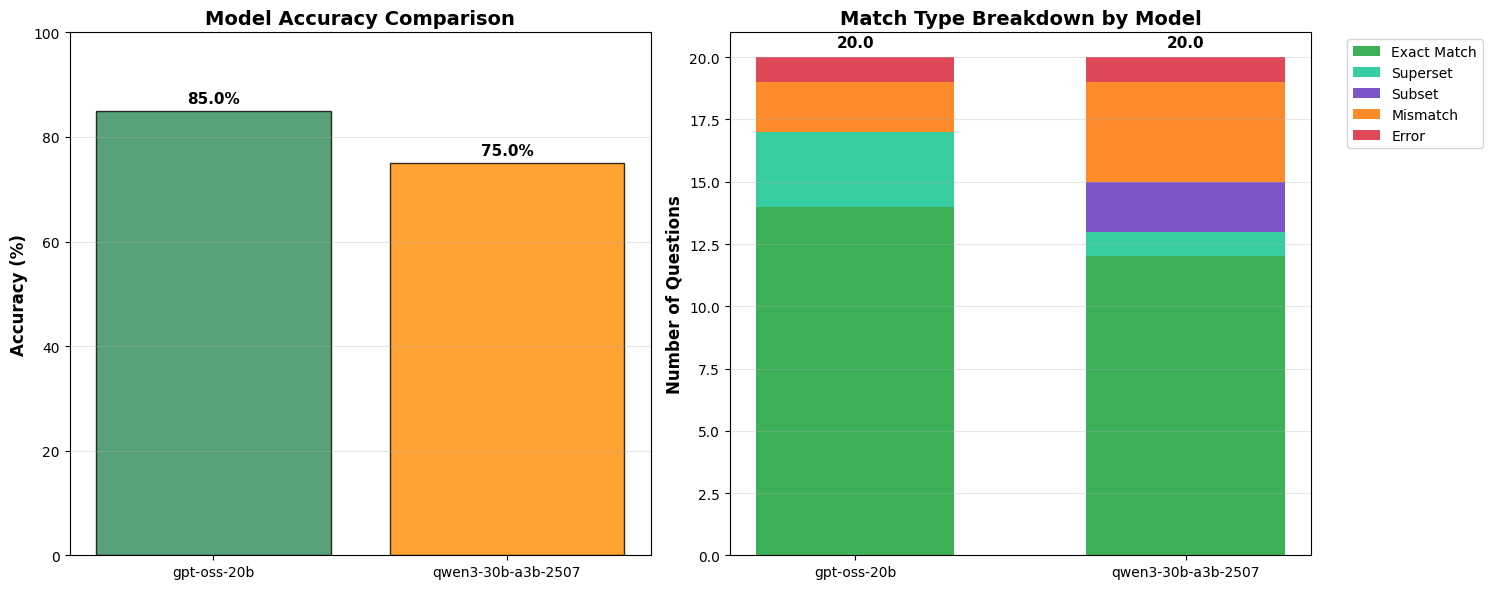


📈 PERFORMANCE SUMMARY:
🤖 gpt-oss-20b:
   • Accuracy: 85.0% (17.0/20 questions)
   • Total Time: 2071.1s
   • Avg Time/Question: 103.55s
   • Breakdown: 14.0 exact, 3.0 superset, 0.0 subset, 2.0 mismatch, 1.0 errors

🤖 qwen3-30b-a3b-2507:
   • Accuracy: 75.0% (15.0/20 questions)
   • Total Time: 1651.0s
   • Avg Time/Question: 82.55s
   • Breakdown: 12.0 exact, 1.0 superset, 2.0 subset, 4.0 mismatch, 1.0 errors



In [40]:
# 📊 Visualization: Model Performance Bar Chart
import matplotlib.pyplot as plt
import numpy as np

# Create a comprehensive bar chart showing model performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: Accuracy and Performance Metrics
models = comparison_table['model'].tolist()
accuracy = comparison_table['accuracy_percent'].tolist()
total_time = comparison_table['total_duration_seconds'].tolist()
avg_time = comparison_table['avg_duration_per_question'].tolist()

# Accuracy bar chart
bars1 = ax1.bar(models, accuracy, color=['#2e8b57', '#ff8c00'], alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

# Add accuracy values on top of bars
for bar, acc in zip(bars1, accuracy):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{acc}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Chart 2: Match Type Breakdown (Stacked Bar)
exact = comparison_table['exact_matches'].tolist()
superset = comparison_table['superset_matches'].tolist()
subset = comparison_table['subset_matches'].tolist()
mismatch = comparison_table['mismatches'].tolist()
errors = comparison_table['errors'].tolist()

# Create stacked bar chart
width = 0.6
x = np.arange(len(models))

p1 = ax2.bar(x, exact, width, label='Exact Match', color='#28a745', alpha=0.9)
p2 = ax2.bar(x, superset, width, bottom=exact, label='Superset', color='#20c997', alpha=0.9)
p3 = ax2.bar(x, subset, width, bottom=np.array(exact) + np.array(superset), label='Subset', color='#6f42c1', alpha=0.9)
p4 = ax2.bar(x, mismatch, width, bottom=np.array(exact) + np.array(superset) + np.array(subset), label='Mismatch', color='#fd7e14', alpha=0.9)
p5 = ax2.bar(x, errors, width, bottom=np.array(exact) + np.array(superset) + np.array(subset) + np.array(mismatch), label='Error', color='#dc3545', alpha=0.9)

ax2.set_ylabel('Number of Questions', fontsize=12, fontweight='bold')
ax2.set_title('Match Type Breakdown by Model', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(axis='y', alpha=0.3)

# Add total values on top of stacked bars
for i, model in enumerate(models):
    total = exact[i] + superset[i] + subset[i] + mismatch[i] + errors[i]
    ax2.text(i, total + 0.3, f'{total}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📈 PERFORMANCE SUMMARY:")
print("=" * 50)
for i, model in enumerate(models):
    print(f"🤖 {model}:")
    print(f"   • Accuracy: {accuracy[i]}% ({comparison_table.iloc[i]['total_correct']}/20 questions)")
    print(f"   • Total Time: {total_time[i]}s")
    print(f"   • Avg Time/Question: {avg_time[i]}s")
    print(f"   • Breakdown: {exact[i]} exact, {superset[i]} superset, {subset[i]} subset, {mismatch[i]} mismatch, {errors[i]} errors")
    print()

In [41]:
# 🔥 COMPLETE TRANSPARENCY - SHOW ABSOLUTELY EVERYTHING 🔥


# Get EVERYTHING - all questions, all models, all match types
all_questions_analysis = duckdb.sql(f"""
    WITH source_results AS (
        SELECT nbr, 
               all_values as source_values,
               sorted_values_hash as source_sorted_hash,
               result_count as source_rows,
               sql_query as source_sql,
               question
        FROM results_filtered_three 
        WHERE model = '{model0}' AND error_details IS NULL
    ),
    model_scores AS (
        SELECT 
            r.model,
            r.nbr,
            r.question,
            r.sql_query as model_sql,
            r.result_count,
            r.error_details,
            s.source_rows,
            s.source_sql,
            CASE 
                WHEN r.error_details IS NOT NULL THEN 'error'
                WHEN r.sorted_values_hash = s.source_sorted_hash THEN 'exact'
                WHEN array_has_all(r.all_values, s.source_values) THEN 'superset'
                WHEN array_has_all(s.source_values, r.all_values) THEN 'subset'
                ELSE 'mismatch'
            END as match_type
        FROM results_filtered_three r
        LEFT JOIN source_results s ON r.nbr = s.nbr
        WHERE r.model IN ('{model1}', '{model2}')
    )
    SELECT nbr, question, model, model_sql, source_sql, result_count, source_rows, match_type, error_details
    FROM model_scores
    ORDER BY nbr, model
""").df()

print(f"📈 COMPLETE ANALYSIS SUMMARY:")
print(f"   Total Comparisons: {len(all_questions_analysis)}")

# Show comprehensive breakdown by match type
match_type_counts = all_questions_analysis['match_type'].value_counts()
for match_type, count in match_type_counts.items():
    emoji = {"exact": "✅", "superset": "⬆️", "subset": "⬇️", "mismatch": "❌", "error": "💥"}.get(match_type, "❓")
    percentage = (count / len(all_questions_analysis)) * 100
    print(f"   {emoji} {match_type}: {count} ({percentage:.1f}%)")
print()

from IPython.display import HTML
import html

# Process EVERY SINGLE QUESTION (1-20)
for question_num in range(1, 21):
    print(f"📋 QUESTION {question_num}")
    print("=" * 80)
    
    # Get question text from reference model
    try:
        question_text = duckdb.sql(f"""
            SELECT question FROM results_filtered_three 
            WHERE model = '{model0}' AND nbr = {question_num}
        """).fetchone()[0]
        print(f"❓ Question: {question_text}")
    except:
        print(f"❓ Question: [Could not retrieve question text]")
    
    # Get data for this question
    question_data = all_questions_analysis[all_questions_analysis['nbr'] == question_num]
    
    if len(question_data) == 0:
        print("⚠️ No data found for this question")
        print("=" * 80 + "\n")
        continue
    
    # Show match status for each model
    print(f"🏷️ Match Results:")
    for _, row in question_data.iterrows():
        model_name = row['model']
        match_type = row['match_type']
        emoji = {"exact": "✅", "superset": "⬆️", "subset": "⬇️", "mismatch": "❌", "error": "💥"}.get(match_type, "❓")
        
        if row['error_details']:
            print(f"   {emoji} {model_name}: {match_type} - {row['error_details']}")
        else:
            print(f"   {emoji} {model_name}: {match_type}")
    print()
    
    # Get reference result and SQL
    try:
        source_sql = duckdb.sql(f"""
            SELECT sql_query FROM results_filtered_three 
            WHERE model = '{model0}' AND nbr = {question_num} AND error_details IS NULL
        """).fetchone()[0]
        
        source_result = con.sql(source_sql).df()
        
        # Get results for all models
        all_models = [model0] + question_data['model'].tolist()
        all_results = [source_result]
        all_sqls = [source_sql]
        all_match_types = ['reference']
        
        # Get results for comparison models
        for _, row in question_data.iterrows():
            model_name = row['model']
            model_sql = row['model_sql']
            match_type = row['match_type']
            
            try:
                if row['error_details']:
                    # Add empty result for errors
                    all_results.append(pd.DataFrame({'Error': [row['error_details']]}))
                    all_sqls.append(model_sql)
                else:
                    model_result = con.sql(model_sql).df()
                    all_results.append(model_result)
                    all_sqls.append(model_sql)
                all_match_types.append(match_type)
            except Exception as e:
                all_results.append(pd.DataFrame({'Execution_Error': [str(e)]}))
                all_sqls.append(model_sql)
                all_match_types.append('execution_error')
        
        # Create comprehensive side-by-side comparison
        if len(all_results) > 1:
            max_rows = max(len(df) for df in all_results if len(df) > 0)
            if max_rows == 0:
                max_rows = 1
            
            padded_results = []
            for i, df in enumerate(all_results):
                if len(df) == 0:
                    padded_df = pd.DataFrame({'No_Data': ['Empty result']})
                elif len(df) < max_rows:
                    empty_rows = max_rows - len(df)
                    if empty_rows > 0:
                        # Create empty DataFrame with proper data types
                        empty_data = {}
                        for col in df.columns:
                            # Use the same dtype as the original column, or object if mixed
                            if len(df) > 0:
                                empty_data[col] = [None] * empty_rows
                            else:
                                empty_data[col] = [None] * empty_rows
                        empty_df = pd.DataFrame(empty_data)
                        
                        # Only concatenate if we have data to concatenate
                        if not df.empty:
                            padded_df = pd.concat([df, empty_df], ignore_index=True)
                        else:
                            padded_df = empty_df
                    else:
                        padded_df = df.copy()
                else:
                    padded_df = df.copy()
                
                padded_results.append(padded_df)
            
            # Create model labels with match types
            model_labels = []
            for i, (model, match_type) in enumerate(zip(all_models, all_match_types)):
                if i == 0:
                    model_labels.append(f'{model} (Reference)')
                else:
                    emoji = {"exact": "✅", "superset": "⬆️", "subset": "⬇️", "mismatch": "❌", "error": "💥", "execution_error": "💥"}.get(match_type, "❓")
                    model_labels.append(f'{model} ({emoji} {match_type})')
            
            # Create multi-column comparison
            side_by_side = pd.concat(padded_results, 
                                   axis=1, 
                                   keys=model_labels[:len(padded_results)])
            
            print("📊 Complete Results Comparison:")
            display(side_by_side)
            
            # Create comprehensive HTML SQL comparison
            html_sections = []
            for i, (model_name, sql_query, match_type) in enumerate(zip(all_models, all_sqls, all_match_types)):
                if i == 0:
                    color = "#2e8b57"
                    bg_color = "#f8f9fa"
                    label = f"{model_name} SQL (Reference)"
                else:
                    emoji = {"exact": "✅", "superset": "⬆️", "subset": "⬇️", "mismatch": "❌", "error": "💥", "execution_error": "💥"}.get(match_type, "❓")
                    
                    if match_type == 'exact':
                        color = "#28a745"  # Green for exact
                        bg_color = "#f8fff8"
                    elif match_type in ['superset', 'subset']:
                        color = "#ff8c00"  # Orange for valid differences
                        bg_color = "#fff8dc"
                    else:
                        color = "#dc3545"  # Red for errors/mismatches
                        bg_color = "#fff5f5"
                    
                    label = f"{model_name} SQL ({emoji} {match_type})"
                
                section = f"""
                    <div style="flex: 1; border: 1px solid #ddd; padding: 10px; min-width: 300px; margin: 5px;">
                        <h4 style="color: {color}; margin-top: 0; margin-bottom: 10px;">{label}</h4>
                        <pre style="background-color: {bg_color}; padding: 10px; border-radius: 4px; white-space: pre-wrap; font-size: 11px; color: black; max-height: 300px; overflow-y: auto;">{html.escape(sql_query)}</pre>
                    </div>"""
                html_sections.append(section)
            
            html_content = f"""
            <div style="display: flex; gap: 10px; margin: 10px 0; flex-wrap: wrap; justify-content: space-around;">
                {''.join(html_sections)}
            </div>
            """
            
            print("🔧 Complete SQL Queries Comparison:")
            display(HTML(html_content))
            
    except Exception as e:
        print(f"❌ Error processing question {question_num}: {e}")
    
    print("=" * 80 + "\n")

print("🎯 COMPLETE ANALYSIS FINISHED - EVERY QUESTION SHOWN")
print("=" * 80)

📈 COMPLETE ANALYSIS SUMMARY:
   Total Comparisons: 40
   ✅ exact: 26 (65.0%)
   ❌ mismatch: 6 (15.0%)
   ⬆️ superset: 4 (10.0%)
   ⬇️ subset: 2 (5.0%)
   💥 error: 2 (5.0%)

📋 QUESTION 1
❓ Question: What is the overall total sales revenue?
🏷️ Match Results:
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact

📊 Complete Results Comparison:


,o3-mini (Reference),gpt-oss-20b (✅ exact),qwen3-30b-a3b-2507 (✅ exact)
,total_sales,total_sales_revenue,total_sales_revenue
0,5.143009e+08,5.143009e+08,5.143009e+08


🔧 Complete SQL Queries Comparison:



📋 QUESTION 2
❓ Question: What is the total number of items sold across all transactions?
🏷️ Match Results:
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact

📊 Complete Results Comparison:


,o3-mini (Reference),gpt-oss-20b (✅ exact),qwen3-30b-a3b-2507 (✅ exact)
,total_quantity,total_items_sold,total_items_sold
0,13939520.0,13939520.0,13939520.0


🔧 Complete SQL Queries Comparison:



📋 QUESTION 3
❓ Question: What is the total monetary value of all returned items?
🏷️ Match Results:
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact

📊 Complete Results Comparison:


,o3-mini (Reference),gpt-oss-20b (✅ exact),qwen3-30b-a3b-2507 (✅ exact)
,total_returns,total_monetary_value_of_returns,total_monetary_value_of_returns
0,26706800.77,26706800.77,26706800.77


🔧 Complete SQL Queries Comparison:



📋 QUESTION 4
❓ Question: List the names of all stores, order by store name.
🏷️ Match Results:
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact

📊 Complete Results Comparison:


,o3-mini (Reference),gpt-oss-20b (✅ exact),qwen3-30b-a3b-2507 (✅ exact)
,s_store_name,store_name,s_store_name
0,ought,ought,ought


🔧 Complete SQL Queries Comparison:



📋 QUESTION 5
❓ Question: What are the different item categories available? Order alphabetically by category name.
🏷️ Match Results:
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact

📊 Complete Results Comparison:


,o3-mini (Reference),gpt-oss-20b (✅ exact),qwen3-30b-a3b-2507 (✅ exact)
,i_category,category_name,i_category
0,Books,Books,Books
1,Children,Children,Children
2,Electronics,Electronics,Electronics
3,Home,Home,Home
4,Jewelry,Jewelry,Jewelry
5,Men,Men,Men
6,Music,Music,Music
7,Shoes,Shoes,Shoes
8,Sports,Sports,Sports


🔧 Complete SQL Queries Comparison:



📋 QUESTION 6
❓ Question: Show total sales revenue for each year, ordered chronologically by year.
🏷️ Match Results:
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact

📊 Complete Results Comparison:


o3-mini (Reference)               gpt-oss-20b (✅ exact)                      \
               d_year   total_sales                  year total_sales_revenue   
0                1998  1.022972e+08                  1998        1.022972e+08   
1                1999  9.937045e+07                  1999        9.937045e+07   
2                2000  1.031840e+08                  2000        1.031840e+08   
3                2001  1.021729e+08                  2001        1.021729e+08   
4                2002  1.002891e+08                  2002        1.002891e+08   
5                2003  8.737749e+05                  2003        8.737749e+05   

  qwen3-30b-a3b-2507 (✅ exact)                      
                        d_year total_sales_revenue  
0                         1998        1.022972e+08  
1                         1999        9.937045e+07  
2                         2000        1.031840e+08  
3                         2001        1.021729e+08  
4                         2002        1.002891e+08  
5                         2003        8.737749e+05

🔧 Complete SQL Queries Comparison:



📋 QUESTION 7
❓ Question: Which store generated the most total sales revenue? (To ensure a deterministic result if there's a tie, you might order by revenue descending and then store name alphabetically).
🏷️ Match Results:
   ✅ gpt-oss-20b: exact
   ⬇️ qwen3-30b-a3b-2507: subset

📊 Complete Results Comparison:


o3-mini (Reference)               gpt-oss-20b (✅ exact)                \
         s_store_name   total_sales          s_store_name   total_sales   
0               ought  5.079412e+08                 ought  5.079412e+08   

  qwen3-30b-a3b-2507 (⬇️ subset)  
                    s_store_name  
0                          ought

🔧 Complete SQL Queries Comparison:



📋 QUESTION 8
❓ Question: What is the total quantity of items sold, broken down by item brand? Order by quantity sold descending, and then by brand name alphabetically for ties.
🏷️ Match Results:
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact

📊 Complete Results Comparison:
📊 Complete Results Comparison:


o3-mini (Reference)                gpt-oss-20b (✅ exact)  \
                i_brand total_quantity                 brand   
0     exportischolar #2       329402.0     exportischolar #2   
1    edu packimporto #2       279745.0    edu packimporto #2   
2       amalgexporti #2       256831.0       amalgexporti #2   
3     importoimporto #2       251018.0     importoimporto #2   
4       importoamalg #2       244138.0       importoamalg #2   
..                  ...            ...                   ...   
513        univbrand #1         2468.0          univbrand #1   
514  corpamalgamalg #17         2457.0    corpamalgamalg #17   
515     exportibrand #9         2391.0       exportibrand #9   
516   univamalgamalg #7         2264.0     univamalgamalg #7   
517     edu packmaxi #1         2027.0       edu packmaxi #1   

                        qwen3-30b-a3b-2507 (✅ exact)                 
    total_quantity_sold                      i_brand total_quantity  
0              329402.0            exportischolar #2       329402.0  
1              279745.0           edu packimporto #2       279745.0  
2              256831.0              amalgexporti #2       256831.0  
3              251018.0            importoimporto #2       251018.0  
4              244138.0              importoamalg #2       244138.0  
..                  ...                          ...            ...  
513              2468.0                 univbrand #1         2468.0  
514              2457.0           corpamalgamalg #17         2457.0  
515              2391.0              exportibrand #9         2391.0  
516              2264.0            univamalgamalg #7         2264.0  
517              2027.0              edu packmaxi #1         2027.0  

[518 rows x 6 columns]

🔧 Complete SQL Queries Comparison:



📋 QUESTION 9
❓ Question: Compare total sales from preferred customers versus non-preferred customers, ordered by total sales
🏷️ Match Results:
   ❌ gpt-oss-20b: mismatch
   ❌ qwen3-30b-a3b-2507: mismatch

📊 Complete Results Comparison:
📊 Complete Results Comparison:


C:\Users\mdjouallah\AppData\Local\Temp\ipykernel_24512\1145069240.py:153: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  padded_df = pd.concat([df, empty_df], ignore_index=True)


o3-mini (Reference)               gpt-oss-20b (❌ mismatch)                \
   preferred_customer   total_sales            customer_type   total_sales   
0                   N  2.461229e+08            Non-Preferred  2.461229e+08   
1                   Y  2.456942e+08                Preferred  2.456942e+08   
2                None  1.625229e+07            Non-Preferred  1.625229e+07   

  qwen3-30b-a3b-2507 (❌ mismatch)                
              customer_preference   total_sales  
0                               Y  2.456942e+08  
1                               N  0.000000e+00  
2                            None           NaN

🔧 Complete SQL Queries Comparison:



📋 QUESTION 10
❓ Question: What is the total return amount for each city where stores are located, ordered alphabetically by city name.
🏷️ Match Results:
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact

📊 Complete Results Comparison:


o3-mini (Reference)               gpt-oss-20b (✅ exact)  \
                 city total_returns                  city   
0              Midway   26153478.62                Midway   

                       qwen3-30b-a3b-2507 (✅ exact)                
  total_returns_amount                         city total_returns  
0          26153478.62                       Midway   26153478.62

🔧 Complete SQL Queries Comparison:



📋 QUESTION 11
❓ Question: What is the net sales for each store name, order by net sales.
🏷️ Match Results:
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact

📊 Complete Results Comparison:


o3-mini (Reference)              gpt-oss-20b (✅ exact)               \
           store_name    net_sales            store_name    net_sales   
0               ought  481787676.8                 ought  481787676.8   

  qwen3-30b-a3b-2507 (✅ exact)               
                    store_name    net_sales  
0                        ought  481787676.8

🔧 Complete SQL Queries Comparison:



📋 QUESTION 12
❓ Question: Calculate the return rate for each item category, ordered alphabetically by item category name.
🏷️ Match Results:
   ✅ gpt-oss-20b: exact
   ⬆️ qwen3-30b-a3b-2507: superset

📊 Complete Results Comparison:
📊 Complete Results Comparison:


o3-mini (Reference)             gpt-oss-20b (✅ exact)                      \
         item_category return_rate         item_category return_rate_percent   
0                Books    5.163511                 Books            5.163511   
1             Children    4.903206              Children            4.903206   
2          Electronics    5.203537           Electronics            5.203537   
3                 Home    5.118729                  Home            5.118729   
4              Jewelry    5.123106               Jewelry            5.123106   
5                  Men    5.331012                   Men            5.331012   
6                Music    5.357483                 Music            5.357483   
7                Shoes    5.145126                 Shoes            5.145126   
8               Sports    5.290199                Sports            5.290199   
9                Women    5.246700                 Women            5.246700   
10                None    0.000000                  None                 NaN   
11                None         NaN                  None            0.000000   

   qwen3-30b-a3b-2507 (⬆️ superset)                                         
                      item_category  total_sales total_returns return_rate  
0                             Books  56231614.81    2903525.42    5.163511  
1                          Children  48923440.85    2398817.12    4.903206  
2                       Electronics  56084975.64    2918402.71    5.203537  
3                              Home  48874282.69    2501742.06    5.118729  
4                           Jewelry  52983266.97    2714389.19    5.123106  
5                               Men  50692116.25    2702402.68    5.331012  
6                             Music  52783919.32    2827889.58    5.357483  
7                             Shoes  47807842.49    2459773.92    5.145126  
8                            Sports  43870221.97    2320822.09    5.290199  
9                             Women  54383250.42    2853326.02    5.246700  
10                             None   1665936.31          0.00    0.000000  
11                             None         0.00     105709.98         NaN

🔧 Complete SQL Queries Comparison:



📋 QUESTION 13
❓ Question: What is the monthly trend of net sales during the year 2001, order by net sales desc
🏷️ Match Results:
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact

📊 Complete Results Comparison:


o3-mini (Reference)              gpt-oss-20b (✅ exact)               \
                 month    net_sales                 month    net_sales   
0                   12  17167258.39                    12  17167258.39   
1                   11  16207294.58                    11  16207294.58   
2                    9  11365462.90                     9  11365462.90   
3                   10  10717099.39                    10  10717099.39   
4                    8  10489886.43                     8  10489886.43   
5                    1   5177088.03                     1   5177088.03   
6                    5   4686864.37                     5   4686864.37   
7                    3   4436523.60                     3   4436523.60   
8                    7   4418270.78                     7   4418270.78   
9                    4   4336369.48                     4   4336369.48   
10                   2   4033130.36                     2   4033130.36   
11                   6   3909591.47                     6   3909591.47   

   qwen3-30b-a3b-2507 (✅ exact)               
                          month    net_sales  
0                            12  17167258.39  
1                            11  16207294.58  
2                             9  11365462.90  
3                            10  10717099.39  
4                             8  10489886.43  
5                             1   5177088.03  
6                             5   4686864.37  
7                             3   4436523.60  
8                             7   4418270.78  
9                             4   4336369.48  
10                            2   4033130.36  
11                            6   3909591.47

🔧 Complete SQL Queries Comparison:



📋 QUESTION 14
❓ Question: Which customer birth country exhibits the highest average return rate Order by average return rate descending ? show only the top country and the return rate
🏷️ Match Results:
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact

📊 Complete Results Comparison:
📊 Complete Results Comparison:


o3-mini (Reference)             gpt-oss-20b (✅ exact)                  \
        birth_country return_rate         birth_country avg_return_rate   
0    MARSHALL ISLANDS    8.010773      MARSHALL ISLANDS        8.010773   

  qwen3-30b-a3b-2507 (✅ exact)              
        customer_birth_country return_rate  
0             MARSHALL ISLANDS    8.010773

🔧 Complete SQL Queries Comparison:



📋 QUESTION 15
❓ Question: List all item product names and total sales that have a return rate greater than 5%, ordered by item product name alphabetically. Return only i_product_name and total_sales columns.
🏷️ Match Results:
   ⬆️ gpt-oss-20b: superset
   ⬇️ qwen3-30b-a3b-2507: subset

📊 Complete Results Comparison:


o3-mini (Reference)             gpt-oss-20b (⬆️ superset)              \
         i_product_name total_sales              product_name total_sales   
0                  able   317464.60                      able   317464.60   
1              ableable   262437.05                  ableable   262437.05   
2          ableableable   114399.12              ableableable   114399.12   
3          ableableeing   132341.75              ableableeing   132341.75   
4      ableableeseought   113558.93          ableableeseought   113558.93   
..                  ...         ...                       ...         ...   
860         pripriation   604846.13               pripriation   604846.13   
861      pripribarought   502711.61            pripribarought   502711.61   
862         priprically   199231.61               priprically   199231.61   
863    pripricallyought   564620.56          pripricallyought   564620.56   
864      priprieseought   197315.89            priprieseought   197315.89   

                              qwen3-30b-a3b-2507 (⬇️ subset)              
    total_returns return_rate                 i_product_name total_sales  
0        18242.98    5.746461                           able   317464.60  
1        18697.28    7.124482                       ableable   262437.05  
2        12521.80   10.945714                   ableableable   114399.12  
3        15900.80   12.014954                   ableableeing   132341.75  
4         6742.09    5.937085               ableableeseought   113558.93  
..            ...         ...                            ...         ...  
860      48263.37    7.979446                    pripriation   604846.13  
861      33192.85    6.602762                 pripribarought   502711.61  
862      13966.02    7.009942                    priprically   199231.61  
863      31938.26    5.656588               pripricallyought   564620.56  
864      13728.33    6.957539                 priprieseought   197315.89  

[865 rows x 8 columns]

🔧 Complete SQL Queries Comparison:



📋 QUESTION 16
❓ Question: For each store, what was the percentage change in net sales between two consecutive recent years (e.g., 2001 and 2002), ordered alphabetically by store name.
🏷️ Match Results:
   ⬆️ gpt-oss-20b: superset
   ❌ qwen3-30b-a3b-2507: mismatch

📊 Complete Results Comparison:
📊 Complete Results Comparison:


C:\Users\mdjouallah\AppData\Local\Temp\ipykernel_24512\1145069240.py:153: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  padded_df = pd.concat([df, empty_df], ignore_index=True)


o3-mini (Reference)                                           \
         s_store_name net_sales_2001 net_sales_2002 pct_change   
0               ought    96358866.54    94602708.88  -1.822518   
1                None            NaN            NaN        NaN   
2                None            NaN            NaN        NaN   
3                None            NaN            NaN        NaN   
4                None            NaN            NaN        NaN   

  gpt-oss-20b (⬆️ superset)                                              \
                     sstore  year     prev_net  current_net  pct_change   
0                     ought  1999  98524927.98  93772296.02   -4.823786   
1                     ought  2000  93772296.02  97320871.87    3.784248   
2                     ought  2001  97320871.87  96358866.54   -0.988488   
3                     ought  2002  96358866.54  94602708.88   -1.822518   
4                     ought  2003  94602708.88  -1343830.40 -101.420499   

  qwen3-30b-a3b-2507 (❌ mismatch)                          
                       store_name pct_change_in_net_sales  
0                           ought               -2.584388  
1                            None                     NaN  
2                            None                     NaN  
3                            None                     NaN  
4                            None                     NaN

🔧 Complete SQL Queries Comparison:



📋 QUESTION 17
❓ Question: What is the return rate for items sold on weekends versus weekdays, broken down by customer age groups (e.g., under 30, 30-45, over 45), ordered by age group.
🏷️ Match Results:
   💥 gpt-oss-20b: error - Execution Error: Max attempts reached. Last error: Binder Error: Ambiguous reference to column name "age_group" (use: "s.age_group" or "r.age_group")
   ❌ qwen3-30b-a3b-2507: mismatch

📊 Complete Results Comparison:
📊 Complete Results Comparison:


C:\Users\mdjouallah\AppData\Local\Temp\ipykernel_24512\1145069240.py:153: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  padded_df = pd.concat([df, empty_df], ignore_index=True)


o3-mini (Reference)                                                       \
            age_group weekend_flag   total_sales total_returns return_rate   
0               30-45            N  8.222361e+07    4280256.91    5.205630   
1               30-45            Y  3.225223e+07    1553206.42    4.815810   
2             Over 45            N  1.565045e+08    8147779.85    5.206100   
3             Over 45            Y  6.436525e+07    3224625.39    5.009885   
4            Under 30            N  1.096806e+08    5516920.95    5.029986   
5            Under 30            Y  4.428833e+07    2325349.37    5.250479   
6             Unknown            N  1.105068e+07     607655.67    5.498809   
7             Unknown            Y  4.671173e+06     200224.04    4.286376   

                               gpt-oss-20b (💥 error)  \
                                               Error   
0  Execution Error: Max attempts reached. Last er...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   
5                                               None   
6                                               None   
7                                               None   

  qwen3-30b-a3b-2507 (❌ mismatch)                                       \
                        age_group day_type   total_sales total_returns   
0                           30-45  Weekday  8.222361e+07    4280256.91   
1                           30-45  Weekend  3.225223e+07    1553206.42   
2                         Over 45  Weekday  1.565045e+08    8147779.85   
3                         Over 45  Weekend  6.436525e+07    3224625.39   
4                        Under 30  Weekday  1.096806e+08    5516920.95   
5                        Under 30  Weekend  4.428833e+07    2325349.37   
6                            None     None           NaN           NaN   
7                            None     None           NaN           NaN   

               
  return_rate  
0    5.205630  
1    4.815810  
2    5.206100  
3    5.009885  
4    5.029986  
5    5.250479  
6         NaN  
7         NaN

🔧 Complete SQL Queries Comparison:



📋 QUESTION 18
❓ Question: Which item brand has shown the largest decrease in its return rate when comparing the average rate of 2001 to 2002, specifically for stores located in the 'TN' state? (Order by the decrease in return rate descending, and then by brand name alphabetically for ties).
🏷️ Match Results:
   ❌ gpt-oss-20b: mismatch
   ❌ qwen3-30b-a3b-2507: mismatch



C:\Users\mdjouallah\AppData\Local\Temp\ipykernel_24512\1145069240.py:153: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  padded_df = pd.concat([df, empty_df], ignore_index=True)


📊 Complete Results Comparison:


o3-mini (Reference)                                               \
               item_brand  rate_2001 rate_2002 decrease_in_return_rate   
0    exportiamalgamalg #5  13.916474  0.843750               13.072724   
1     exportiunivamalg #3  18.199075  6.369521               11.829555   
2       maxiunivamalg #13   9.189426  1.439496                7.749930   
3        corpunivamalg #7   8.067342  0.487251                7.580091   
4          scholarmaxi #8   7.526645  0.476072                7.050572   
..                    ...        ...       ...                     ...   
593                  None        NaN       NaN                     NaN   
594                  None        NaN       NaN                     NaN   
595                  None        NaN       NaN                     NaN   
596                  None        NaN       NaN                     NaN   
597                  None        NaN       NaN                     NaN   

    gpt-oss-20b (❌ mismatch)              qwen3-30b-a3b-2507 (❌ mismatch)  \
                     i_brand decrease_pct                      item_brand   
0       exportiunivamalg #12    21.075982              univamalgamalg #13   
1           brandnameless #2    18.776905               corpunivamalg #11   
2            importobrand #8    17.445828             namelessnameless #8   
3               amalgmaxi #4    17.099925              importonameless #4   
4         amalgunivamalg #10    15.408743                    brandcorp #4   
..                       ...          ...                             ...   
593            corpbrand #10   -11.228757                            None   
594             amalgmaxi #4   -11.977070                            None   
595         brandnameless #2   -11.979300                            None   
596         edu packbrand #6   -12.034688                            None   
597       amalgunivamalg #10   -13.272667                            None   

                          
    return_rate_decrease  
0               3.984515  
1               3.347306  
2               1.946521  
3               1.895204  
4               1.871008  
..                   ...  
593                  NaN  
594                  NaN  
595                  NaN  
596                  NaN  
597                  NaN  

[598 rows x 8 columns]

🔧 Complete SQL Queries Comparison:



📋 QUESTION 19
❓ Question: For each item class, compare the average net sales value per sales transaction between preferred and non-preferred customers. Order by average net sales descending, and then by item class name alphabetically for ties.
🏷️ Match Results:
   ⬆️ gpt-oss-20b: superset
   💥 qwen3-30b-a3b-2507: error - Execution Error: Max attempts reached. Last error: Binder Error: column "total_sales" must appear in the GROUP BY clause or must be part of an aggregate function.
Either add it to the GROUP BY list, or use "ANY_VALUE(total_sales)" if the exact value of "total_sales" is not important.

LINE 25:     COALESCE(s.total_sales, 0) - COALESCE(r.total_returns, 0) AS net_sales...
                      ^



C:\Users\mdjouallah\AppData\Local\Temp\ipykernel_24512\1145069240.py:153: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  padded_df = pd.concat([df, empty_df], ignore_index=True)


📊 Complete Results Comparison:


o3-mini (Reference)                                      \
                i_class c_preferred_cust_flag avg_net_sales   
0               earings                  None   2532.885873   
1                custom                  None   2363.180714   
2              monitors                  None   2272.177463   
3             self-help                  None   2269.849091   
4        entertainments                  None   2174.550328   
..                  ...                   ...           ...   
396                None                  None           NaN   
397                None                  None           NaN   
398                None                  None           NaN   
399                None                  None           NaN   
400                None                  None           NaN   

    gpt-oss-20b (⬆️ superset)                                 \
                   item_class preferred_flag net_sales_total   
0                     earings           None       159571.81   
1                      custom           None       132338.12   
2                    monitors           None       152235.89   
3                   self-help           None       124841.70   
4              entertainments           None       132647.57   
..                        ...            ...             ...   
396                    womens           None        -8234.77   
397              womens watch           None        -7834.68   
398                      None              Y       -75730.28   
399                      None              N       -41495.28   
400                      None           None        -2278.58   

                                                     \
    transaction_count avg_net_sales_per_transaction   
0                  63                   2532.885873   
1                  56                   2363.180714   
2                  67                   2272.177463   
3                  55                   2269.849091   
4                  61                   2174.550328   
..                ...                           ...   
396                 0                           NaN   
397                 0                           NaN   
398                 0                           NaN   
399                 0                           NaN   
400                 0                           NaN   

                          qwen3-30b-a3b-2507 (💥 error)  
                                                 Error  
0    Execution Error: Max attempts reached. Last er...  
1                                                 None  
2                                                 None  
3                                                 None  
4                                                 None  
..                                                 ...  
396                                               None  
397                                               None  
398                                               None  
399                                               None  
400                                               None  

[401 rows x 9 columns]

🔧 Complete SQL Queries Comparison:



📋 QUESTION 20
❓ Question: show all stores net sales , average net sales and percentage of net sales compared to average net sales for each store, ordered by percentage of net sales descending.
🏷️ Match Results:
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact

📊 Complete Results Comparison:


o3-mini (Reference)                                                  \
         s_store_name    net_sales avg_net_sales pct_net_sales_vs_avg   
0               ought  481787676.8   481787676.8                100.0   

  gpt-oss-20b (✅ exact)                                        \
             store_name    net_sales avg_net_sales pct_of_avg   
0                 ought  481787676.8   481787676.8      100.0   

  qwen3-30b-a3b-2507 (✅ exact)                                                  
                    store_name    net_sales avg_net_sales pct_of_avg_net_sales  
0                        ought  481787676.8   481787676.8                100.0

🔧 Complete SQL Queries Comparison:



🎯 COMPLETE ANALYSIS FINISHED - EVERY QUESTION SHOWN
